# Credit Card Fraud Prediction models

In [397]:
# importing everything we will be using 

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#pd.set_option("display.max_rows", None)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

In [398]:
#importing data

data = pd.read_csv('User0_credit_card_transactions copie.csv')

## Data description

In [399]:
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [400]:
data.shape

(19963, 15)

In [401]:
data.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?'],
      dtype='object')

In [402]:
data.describe()

,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,19963.0,19963.000000,19963.000000,19963.000000,19963.000000,1.996300e+04,18316.000000,19963.000000
mean,0.0,1.910735,2011.011922,6.568101,15.743876,7.825653e+17,88812.744922,5617.940239
std,0.0,1.237763,5.048146,3.477497,8.801378,4.040602e+18,13711.491085,707.982901
min,0.0,0.000000,2002.000000,1.000000,1.000000,-9.179793e+18,1012.000000,1711.000000
25%,0.0,0.000000,2007.000000,4.000000,8.000000,-1.288082e+18,91750.000000,5311.000000
50%,0.0,2.000000,2011.000000,7.000000,16.000000,8.384250e+17,91750.000000,5499.000000
75%,0.0,3.000000,2015.000000,10.000000,23.000000,4.060647e+18,91752.000000,5912.000000
max,0.0,4.000000,2020.000000,12.000000,31.000000,9.137769e+18,99504.000000,9402.000000


In [403]:
data.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

## DATA CLEANING

In [404]:
#data.duplicated().sum()##
#data.drop_duplicates() # checking and dropping duplicates 

# NO DUPLICATES

In [405]:
# droping the column User because it has too many unique values,the User column had no unique values 
# User is just an index not an ID 

data.drop(['User'], axis=1, inplace=True)

In [406]:
# check for NaN values 
data.isna().sum()

Card                  0
Year                  0
Month                 0
Day                   0
Time                  0
Amount                0
Use Chip              0
Merchant Name         0
Merchant City         0
Merchant State     1317
Zip                1647
MCC                   0
Errors?           19389
Is Fraud?             0
dtype: int64

In [407]:
# add Year, Month , Day to one column Called Date
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
# change the data type of the Date column to object
data['Date'] = data['Date'].astype('object')

#Drop year and day, leave month for analysis 

data.drop(['Year','Day'], axis=1, inplace=True) #keep months 

In [408]:
# create a list of column names in the desired order
column_order = ['Card', 'Date','Month', 'Time', 'Amount', 'Use Chip', 'Merchant Name',
           'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?']

# reorder the columns in the DataFrame
data = data[column_order]

In [409]:
# check for Month where frauds accured the most 
fraud_transactions = data[data['Is Fraud?'] == 'Yes']
# Display the fraudulent transactions based on the 'Time' column
print(fraud_transactions.sort_values(by='Month'))

       Card        Date  Month   Time    Amount            Use Chip  \
17738     3  2016-02-23      2  14:38    $22.40   Swipe Transaction   
17737     3  2016-02-23      2  10:26   $244.23  Online Transaction   
9762      2  2016-03-06      3  12:10   $297.86  Online Transaction   
9761      2  2016-03-06      3  11:18    $81.93    Chip Transaction   
13678     3  2008-10-10     10  09:37    $11.04   Swipe Transaction   
13699     3  2008-10-20     10  09:23  $-298.00   Swipe Transaction   
13698     3  2008-10-20     10  09:03    $29.53   Swipe Transaction   
13690     3  2008-10-13     10  08:13   $196.10   Swipe Transaction   
13689     3  2008-10-13     10  08:10   $245.41   Swipe Transaction   
13688     3  2008-10-13     10  07:08    $75.41   Swipe Transaction   
13687     3  2008-10-13     10  07:02     $3.72   Swipe Transaction   
13685     3  2008-10-12     10  15:58   $298.00   Swipe Transaction   
13684     3  2008-10-12     10  15:54    $96.19   Swipe Transaction   
13683 

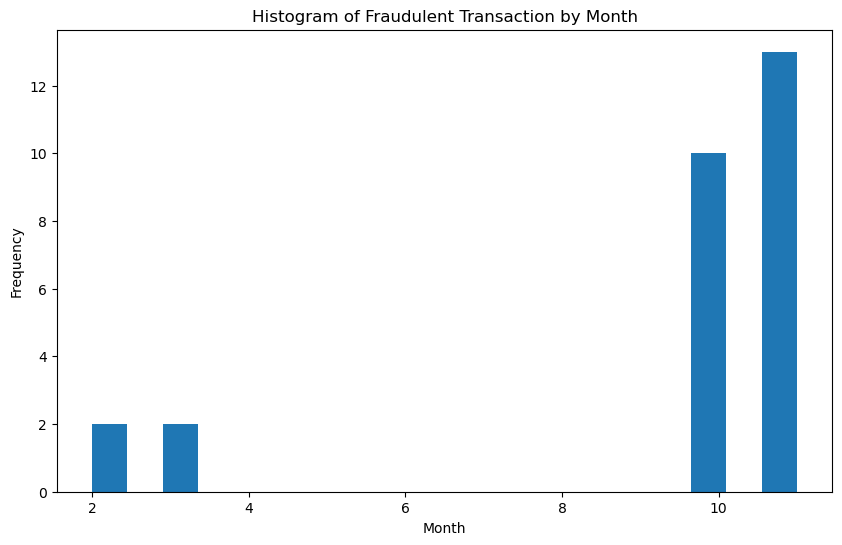

In [410]:
# Sort fraudulent transactions by 'Month'
sorted_fraud_transactions = fraud_transactions.sort_values(by='Month')
# Create a plot of fraudulent transaction over months
plt.figure(figsize=(10, 6))
plt.hist(fraud_transactions['Month'], bins=20)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transaction by Month')
plt.show()

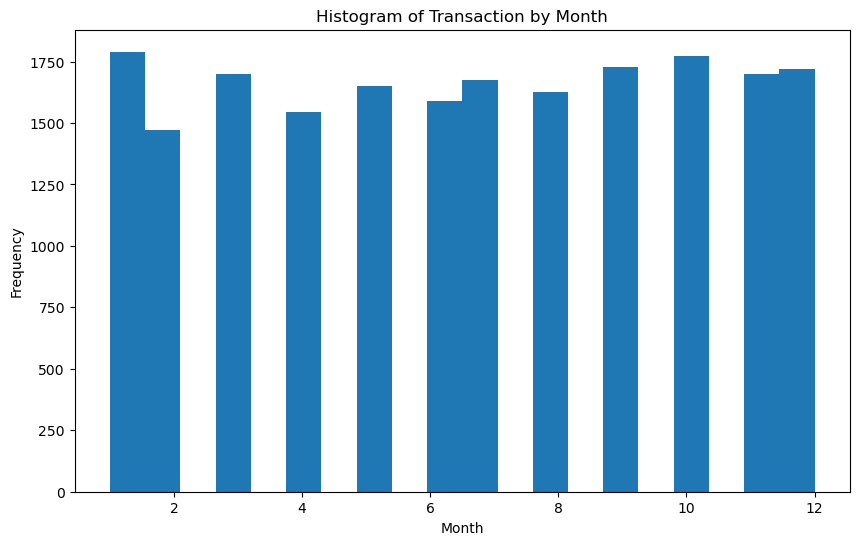

In [411]:
# Create a plot of transaction over months
plt.figure(figsize=(10, 6))
plt.hist(data['Month'], bins=20)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction by Month')
plt.show()

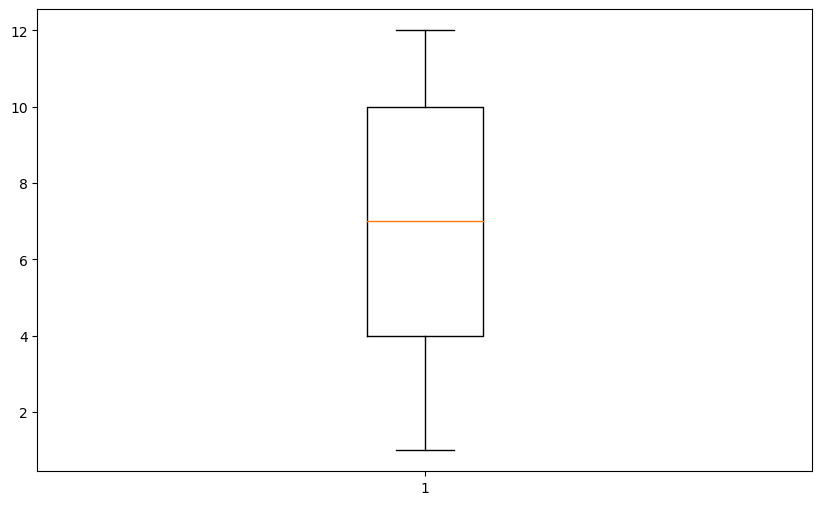

In [412]:
## Checking for outliers in Month 
# Create a box plot of fraudulent transaction amounts
plt.figure(figsize=(10, 6))
plt.boxplot(data['Month'])
plt.show()

### Column Time 

In [413]:
data.head()

,Card,Date,Month,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,2002-09-01,9,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,2002-09-01,9,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,2002-09-02,9,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,2002-09-02,9,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,2002-09-03,9,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [414]:
#Add column Morning or Night
# Check which Time most frauds accured, morning or night ? 

data['Time'].min()
data['Time'].max()
# create of function to classify time to morning and night
import datetime
def classify_time(time_str):
    time_obj = pd.to_datetime(time_str).time()
    if time_obj >= datetime.time(6, 0) and time_obj <= datetime.time(11, 59):
        return "morning"
    else:
        return "night"
    
data["Time Period"] = data["Time"].apply(classify_time)

In [415]:
## check where Frauds happened most using Time column 


       Card        Date  Month   Time    Amount            Use Chip  \
9761      2  2016-03-06      3  11:18    $81.93    Chip Transaction   
17737     3  2016-02-23      2  10:26   $244.23  Online Transaction   
4112      0  2015-11-20     11  07:42  $-473.00  Online Transaction   
4111      0  2015-11-20     11  07:34   $162.11  Online Transaction   
13687     3  2008-10-13     10  07:02     $3.72   Swipe Transaction   
13688     3  2008-10-13     10  07:08    $75.41   Swipe Transaction   
13678     3  2008-10-10     10  09:37    $11.04   Swipe Transaction   
13689     3  2008-10-13     10  08:10   $245.41   Swipe Transaction   
13698     3  2008-10-20     10  09:03    $29.53   Swipe Transaction   
4104      0  2015-11-16     11  11:34   $144.49  Online Transaction   
4103      0  2015-11-16     11  11:20   $473.00  Online Transaction   
4102      0  2015-11-16     11  09:46   $248.36  Online Transaction   
4101      0  2015-11-16     11  09:41    $50.81  Online Transaction   
13699 

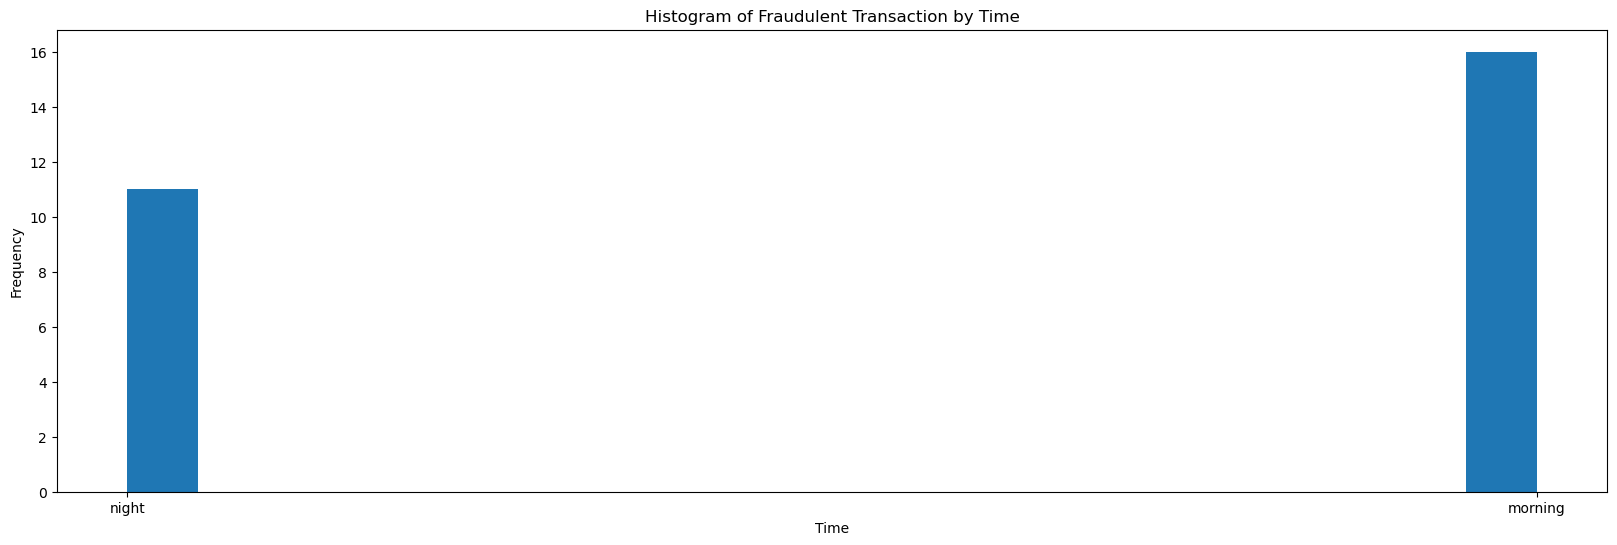

In [416]:
# check for Time where frauds accured the most 
fraud_transactions = data[data['Is Fraud?'] == 'Yes']
# Display the fraudulent transactions based on the 'Time' column
print(fraud_transactions.sort_values(by='Time Period'))
# Sort fraudulent transactions by 'Time'
sorted_fraud_transactions = fraud_transactions.sort_values(by='Time Period')
# Create a plot of fraudulent transaction over Time
plt.figure(figsize=(20, 6))
plt.hist(fraud_transactions['Time Period'], bins=20)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transaction by Time')
plt.show()

In [417]:
## Most Fraudulents happened at Morning 

### Column amount 

In [418]:
## clean column Amount, remove the $ sign 
data['Amount'] = data['Amount'].str.replace('$', '').astype(float).round(0)

       Card        Date  Month   Time  Amount            Use Chip  \
4112      0  2015-11-20     11  07:42  -473.0  Online Transaction   
13699     3  2008-10-20     10  09:23  -298.0   Swipe Transaction   
4100      0  2015-11-15     11  13:19     2.0  Online Transaction   
13687     3  2008-10-13     10  07:02     4.0   Swipe Transaction   
13678     3  2008-10-10     10  09:37    11.0   Swipe Transaction   
4109      0  2015-11-17     11  16:05    18.0  Online Transaction   
17738     3  2016-02-23      2  14:38    22.0   Swipe Transaction   
13698     3  2008-10-20     10  09:03    30.0   Swipe Transaction   
4105      0  2015-11-16     11  13:44    45.0  Online Transaction   
4101      0  2015-11-16     11  09:41    51.0  Online Transaction   
4106      0  2015-11-17     11  14:12    65.0  Online Transaction   
13683     3  2008-10-12     10  11:52    69.0   Swipe Transaction   
13688     3  2008-10-13     10  07:08    75.0   Swipe Transaction   
9761      2  2016-03-06      3  11

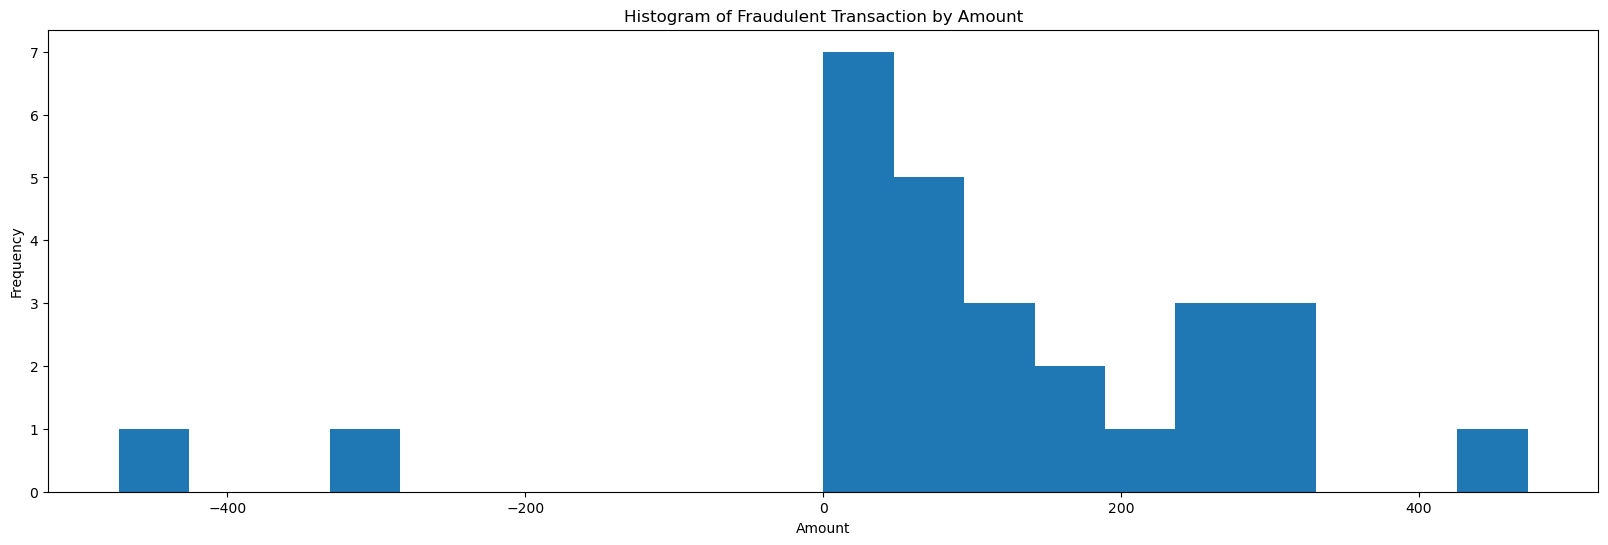

In [419]:
## Check the limit, where most frauds accured, more than X number 
# check for Amount where frauds accured the most 
fraud_transactions = data[data['Is Fraud?'] == 'Yes']
# Display the fraudulent transactions based on the 'Time' column
print(fraud_transactions.sort_values(by='Amount'))
# Sort fraudulent transactions by 'Time'
sorted_fraud_transactions = fraud_transactions.sort_values(by='Amount')
# Create a plot of fraudulent transaction over Time
plt.figure(figsize=(20, 6))
plt.hist(fraud_transactions['Amount'], bins=20)
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transaction by Amount')
plt.show()

(array([4.700e+01, 3.000e+01, 4.600e+01, 5.100e+01, 4.760e+02, 9.808e+03,
        8.352e+03, 8.330e+02, 7.900e+01, 8.400e+01, 4.800e+01, 2.000e+01,
        1.600e+01, 1.700e+01, 2.300e+01, 2.100e+01, 7.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00]),
 array([-499. , -403.6, -308.2, -212.8, -117.4,  -22. ,   73.4,  168.8,
         264.2,  359.6,  455. ,  550.4,  645.8,  741.2,  836.6,  932. ,
        1027.4, 1122.8, 1218.2, 1313.6, 1409. ]),
 <BarContainer object of 20 artists>)

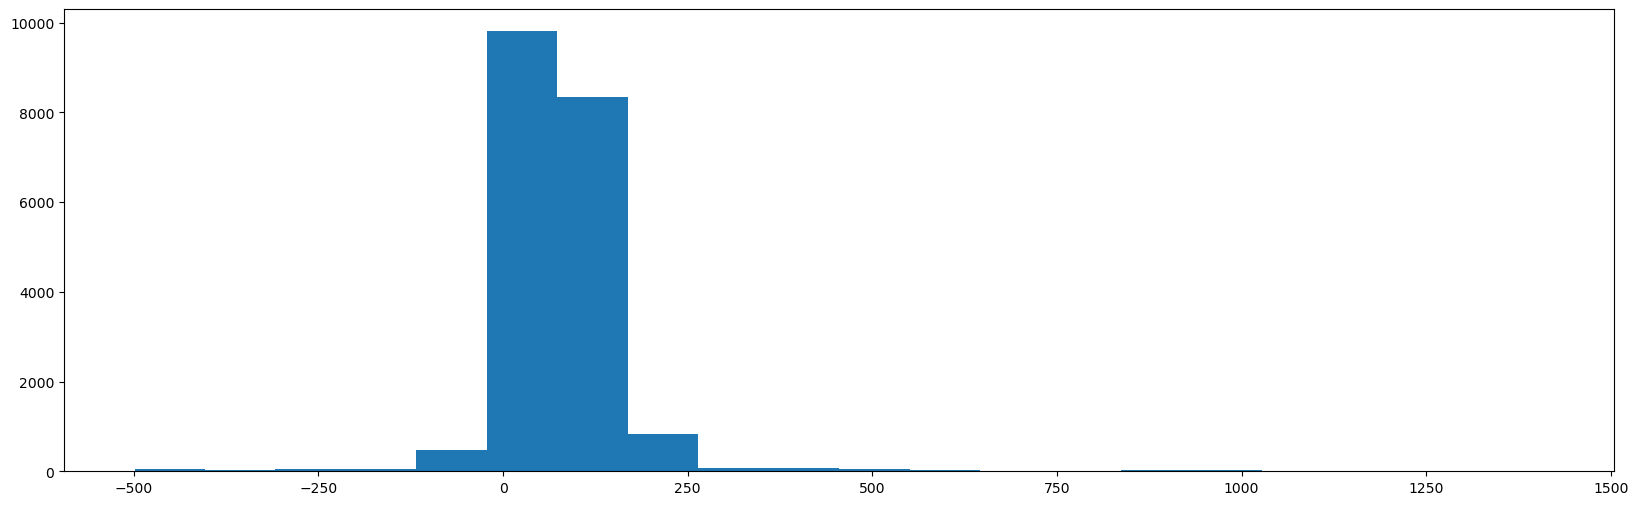

In [420]:
## Plot for Amount 
# Create a plot of transaction Amounts
plt.figure(figsize=(20, 6))
plt.hist(data['Amount'], bins=20)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f805900a430>,
 'caps': [<matplotlib.lines.Line2D at 0x7f805900a3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8058c6df10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f805a670070>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f805a670b50>],
 'means': []}

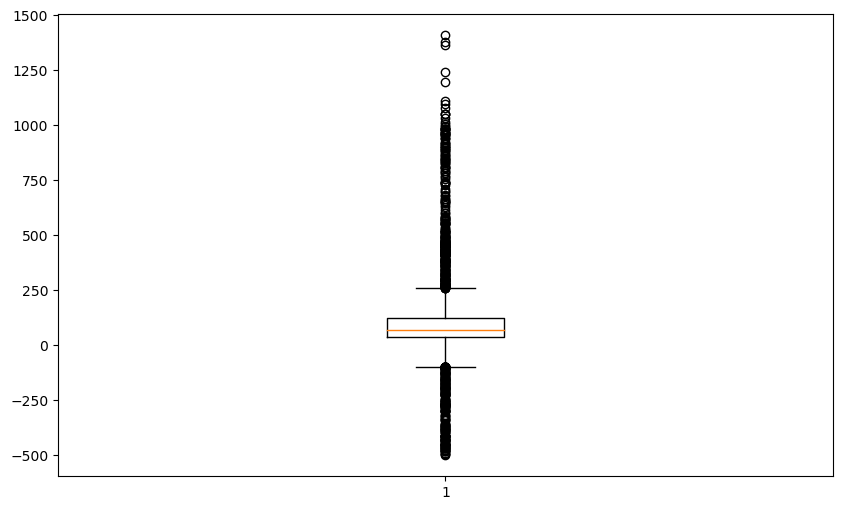

In [421]:
## Check for outliers 
plt.figure(figsize=(10, 6))
plt.boxplot(data['Amount'])

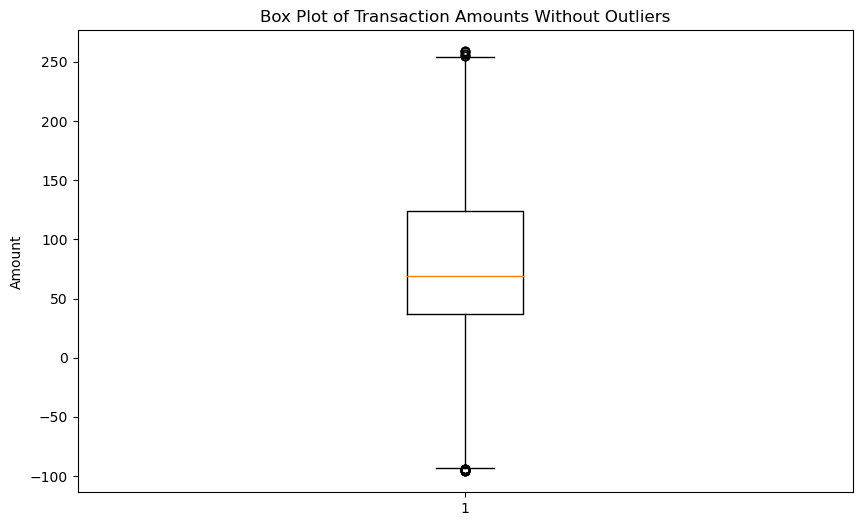

In [422]:
## Removing outliers 
# Calculate the 1st quartile, 3rd quartile, and IQR for the 'Amount' column
Q1 = data['Amount'].quantile(0.25)
Q3 = data['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the dataset
data_cleaned = data[(data['Amount'] >= lower_bound) & (data['Amount'] <= upper_bound)]

# Create a box plot of the cleaned 'Amount' column
plt.figure(figsize=(10, 6))
plt.boxplot(data_cleaned['Amount'])
plt.ylabel('Amount')
plt.title('Box Plot of Transaction Amounts Without Outliers')
plt.show()

In [423]:
fraud = data_cleaned[data_cleaned['Is Fraud?']=='Yes']
fraud.shape

(21, 14)

In [424]:
## Fraudulent transacrtion went from 27 to 21, fraudulent transactions accured in outliers
## I won't remove outliers

In [425]:
data['Amount'].value_counts

<bound method IndexOpsMixin.value_counts of 0         134.0
1          38.0
2         120.0
3         129.0
4         105.0
5          86.0
6          94.0
7         124.0
8          62.0
9          57.0
10         76.0
11         54.0
12        110.0
13        117.0
14         45.0
15         29.0
16        147.0
17         28.0
18         77.0
19         23.0
20         38.0
21         66.0
22         56.0
23          3.0
24        145.0
25        160.0
26        102.0
27         37.0
28         29.0
29        162.0
30         34.0
31         62.0
32        -99.0
33         99.0
34         80.0
35        122.0
36         93.0
37         53.0
38          1.0
39        127.0
40         44.0
41        164.0
42         13.0
43        110.0
44        126.0
45         41.0
46         81.0
47        115.0
48         44.0
49        120.0
50        160.0
51        129.0
52         92.0
53        168.0
54         53.0
55        105.0
56        120.0
57        146.0
58         48.0
59          

### Cleaning Merchant city : add column to type of transaction ( online or in-person )   

In [426]:
data['Merchant City'].value_counts()

La Verne               10874
Monterey Park           2864
Mira Loma               2406
ONLINE                  1317
Cancun                   112
Ontario                  100
Las Vegas                 84
Marlton                   78
Spring Valley             63
Diamond Bar               59
Los Angeles               54
Muscatine                 50
San Antonio               47
Manila                    46
Kingston                  46
Chicago                   45
Hawthorne                 43
Seattle                   39
Plymouth                  38
Syracuse                  38
Westville                 36
Palo Alto                 36
Oakland                   35
Cabo San Lucas            34
Rome                      32
Waianae                   31
Simi Valley               30
West Jordan               30
Bakersfield               28
Oceanside                 28
Yorba Linda               25
Anchorage                 24
Austin                    24
Evanston                  23
San Diego     

In [427]:
# create a function to categorize merchant type to online and in-person
def categorize_merchant(city):
    if city == 'ONLINE':
        return 'online'
    else:
        return 'in-person'

# Apply the categorize_city function to the 'Merchant City' column
data['Merchant Type'] = data['Merchant City'].apply(categorize_merchant)

  Merchant City  Amount
4        ONLINE      15
1     Claremont       3
2        Corona       3
6        Upland       3
0   Chula Vista       1
3      La Verne       1
5      Pasadena       1


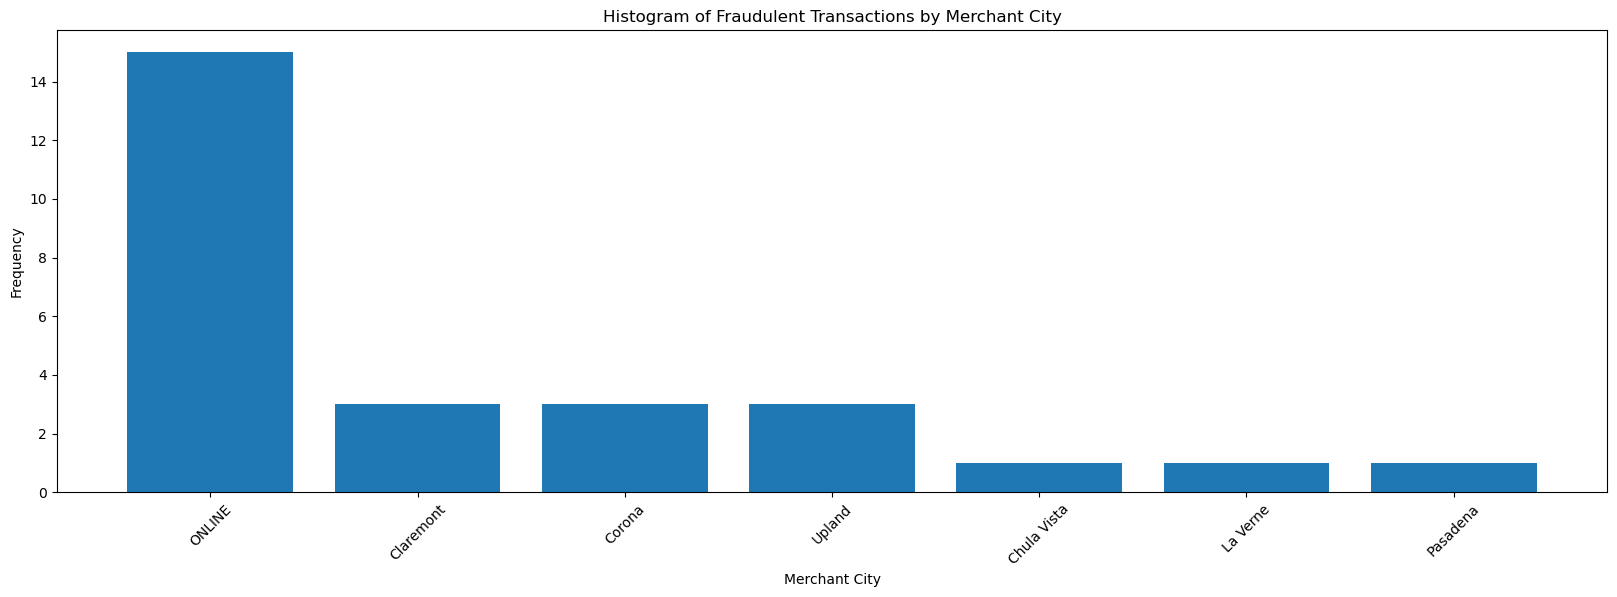

In [428]:
## check for frauds in Merchant City 
# Group fraudulent transactions by 'Merchant City' and count the number of occurrences
fraud_transactions_by_city = fraud_transactions.groupby('Merchant City')['Amount'].count().reset_index()

# Sort fraudulent transactions by count
sorted_fraud_transactions_by_city = fraud_transactions_by_city.sort_values(by='Amount', ascending=False)

# Display the sorted fraudulent transactions by 'Merchant City'
print(sorted_fraud_transactions_by_city)

# Create a histogram of fraudulent transactions by 'Merchant City'
plt.figure(figsize=(20, 6))
plt.bar(sorted_fraud_transactions_by_city['Merchant City'], sorted_fraud_transactions_by_city['Amount'])
plt.xlabel('Merchant City')
plt.ylabel('Frequency')
plt.title('Histogram of Fraudulent Transactions by Merchant City')
plt.xticks(rotation=45)
plt.show()


In [429]:
## 17 fraudulent cases happened online , we keep merchant type and drop merchant city 


In [430]:
data = data.drop('Merchant City', axis=1)

In [431]:
data.head()

,Card,Date,Month,Time,Amount,Use Chip,Merchant Name,Merchant State,Zip,MCC,Errors?,Is Fraud?,Time Period,Merchant Type
0,0,2002-09-01,9,06:21,134.0,Swipe Transaction,3527213246127876953,CA,91750.0,5300,NaN,No,morning,in-person
1,0,2002-09-01,9,06:42,38.0,Swipe Transaction,-727612092139916043,CA,91754.0,5411,NaN,No,morning,in-person
2,0,2002-09-02,9,06:22,120.0,Swipe Transaction,-727612092139916043,CA,91754.0,5411,NaN,No,morning,in-person
3,0,2002-09-02,9,17:45,129.0,Swipe Transaction,3414527459579106770,CA,91754.0,5651,NaN,No,night,in-person
4,0,2002-09-03,9,06:23,105.0,Swipe Transaction,5817218446178736267,CA,91750.0,5912,NaN,No,morning,in-person


In [432]:
## Dropping Merchant State 
#data = data.drop('Merchant State', axis=1)
data.head()

,Card,Date,Month,Time,Amount,Use Chip,Merchant Name,Zip,MCC,Errors?,Is Fraud?,Time Period,Merchant Type
0,0,2002-09-01,9,06:21,134.0,Swipe Transaction,3527213246127876953,91750.0,5300,NaN,No,morning,in-person
1,0,2002-09-01,9,06:42,38.0,Swipe Transaction,-727612092139916043,91754.0,5411,NaN,No,morning,in-person
2,0,2002-09-02,9,06:22,120.0,Swipe Transaction,-727612092139916043,91754.0,5411,NaN,No,morning,in-person
3,0,2002-09-02,9,17:45,129.0,Swipe Transaction,3414527459579106770,91754.0,5651,NaN,No,night,in-person
4,0,2002-09-03,9,06:23,105.0,Swipe Transaction,5817218446178736267,91750.0,5912,NaN,No,morning,in-person


### Column Merchant State 

In [433]:
data['Merchant State'].value_counts(dropna=False)

KeyError: 'Merchant State'

In [395]:
## NaN values = 1317, same number as online merchant type. Check if true or not. 

In [396]:
## check for frauds in Merchant State
## We make an asumption than Nan = Online 
## we check the Nan Values  rows 
nan_rows = data[data['Merchant State'].isna()]
#print(nan_rows)
## all are online , assumption TRUE 

KeyError: 'Merchant State'

In [ ]:
# Replace NaN values with 'online'
#data['Merchant State'] = data['Merchant State'].fillna('Online')

# Group fraudulent transactions by 'Merchant City' and count the number of occurrences
#fraud_transactions_by_state = fraud_transactions.groupby('Merchant State')['Amount'].count().reset_index()

# Sort fraudulent transactions by count
#sorted_fraud_transactions_by_state = fraud_transactions_by_state.sort_values(by='Amount', ascending=False)

# Display the sorted fraudulent transactions by 'Merchant State'
#print(sorted_fraud_transactions_by_state)

# Create a histogram of fraudulent transactions by 'Merchant City'
#plt.figure(figsize=(20, 6))
#plt.bar(sorted_fraud_transactions_by_state['Merchant State'], sorted_fraud_transactions_by_state['Amount'])
#plt.xlabel('Merchant State')
#plt.ylabel('Frequency')
#plt.title('Histogram of Fraudulent Transactions by Merchant state')
#plt.xticks(rotation=45)
#plt.show()

In [ ]:
## Most Frauds happened in CA and Online , we make 4 groups for marchant city
data['Merchant State'].value_counts(dropna=False)
def group_merchant_city(city):
    if city == 'Online':
        return 'Online'
    elif city == 'CA':
        return 'USA CA'
    elif len(city) == 2:
        return 'US not CA'
    else:
        return 'Outside US'
data['Merchant State_grouped'] = data['Merchant State'].apply(group_merchant_city)
data.head()


In [ ]:
data['Merchant State_grouped'].value_counts()

### Dealing with MCC Column 

In [ ]:
data.head()

In [ ]:
# MCC presents the Merchant category code, from this table : 
#https://www.checkout.com/docs/resources/codes/merchant-category-codes
# we see that each number presents a category name, below I will create a new column 

In [ ]:
## Extracted MCC from Values counts 
# MCC = '5411','5912','5300','5541','5311','5812','5499','5942','7538','4900','5814','4814','5310','4829','5815','7230','5211','7832','4899','5651','7349','4722','5193','5813','5719','6300','3722','5970','3684','7011','7210','3509','7542','5251','5921','3596','3780','3730','3640','3504','3775','5655','3389','3390','8043','8021','3359','3387','3395','7996','4214','8099','3771','9402','5621','3000','3405','8011','3393','7995','5712','3256','3001','5661','3058','4131','4121','4511','3066','3132','5094','8041','5732','5932','8111','3174','7802','3260','1711','4112','7801','7531','5733','5533','8049','3007','3008','3006','7922','5816','4411','7549','5947','3009'
         

In [ ]:
# MCC description mapping
mcc_description = {
     1711: "Air Conditioning Contractors – Sales and Installation, Heating Contractors – Sales, Service, Installation",
    3000: "UNITED AIRLINES",
    3001: "AMERICAN AIRLINES",
    3006: "JAPAN AIRLINES",
    3007: "AIR FRANCE",
    3008: "LUFTHANSA",
    3009: "AIR CANADA",
    3058: "DELTA",
    3066: "SOUTHWEST",
    3132: "Airlines",
    3174: "Airlines",
    3256: "ALASKA AIRLINES",
    3260: "Airlines",
    3359: "PAYLESS CAR RENTAL",
    3387: "ALAMO RENT-A-CAR",
    3389: "AVIS RENT-A-CAR",
    3390: "DOLLAR RENT-A-CAR",
    3393: "NATIONAL CAR RENTAL",
    3395: "THRIFTY RENT-A-CAR",
    3405: "ENTERPRISE RENT-A-CAR",
    3504: "HILTON HOTELS",
    3509: "MARRIOTT HOTELS",
    3596: "Hotels/Motels/Inns/Resorts",
    3640: "HYATT HOTEL",
    3684: "BUDGET HOST INNS",
    3722: "WYNDHAM HOTEL AND RESORTS",
    3730: "MGM GRAND HOTEL",
    3771: "Hotels/Motels/Inns/Resorts",
    3775: "Hotels/Motels/Inns/Resorts",
    3780: "Hotels/Motels/Inns/Resorts",
    4112: "Passenger Railways",
    4121: "Taxicabs and Limousines",
    4131: "Bus Lines, Including Charters, Tour Buses",
    4214: "Motor Freight Carriers, Moving and Storage Companies, Trucking – Local/Long Distance, Delivery Services – Local",
    4411: "Cruise and Steamship Lines",
    4511: "Airlines, Air Carriers (not listed elsewhere)",
    4722: "Travel Agencies and Tour Operations",
    4814: "Fax services, Telecommunication Services",
    4829: "Money Orders – Wire Transfer",
    4899: "Cable and other pay television (previously Cable Services)",
    4900: "Electric, Gas, Sanitary and Water Utilities",
    5094: "Precious Stones and Metals, Watches and Jewelry",
    5193: "Florists’ Supplies, Nursery Stock and Flowers",
    5211: "Lumber and Building Materials Stores",
    5251: "Hardware Stores",
    5300: "Wholesale Clubs",
    5310: "Discount Stores",
    5311: "Department Stores",
    5411: "Grocery Stores, Supermarkets",
    5499: "Misc. Food Stores – Convenience Stores and Specialty Markets",
    5533: "Automotive Parts, Accessories Stores",
    5541: "Service Stations (with or without ancillary services)",
    5621: "Women’s Ready-to-Wear Stores",
    5651: "Family Clothing Stores",
    5655: "Sports Apparel, Riding Apparel Stores",
    5661: "Shoe Stores",
    5712: "Furniture, Home Furnishings, and Equipment Stores, Except Appliances",
    5719: "Miscellaneous Home Furnishing Specialty Stores",
    5732: "Electronic Sales",
    5733: "Music Stores, Musical Instruments, Piano Sheet Music",
    5812: "Eating places and Restaurants",
    5813: "Drinking Places (Alcoholic Beverages), Bars, Taverns, Cocktail lounges, Nightclubs and Discotheques",
    5814: "Fast Food Restaurants",
    5815: "Digital Goods: Media, Books, Movies, Music",
    5816: "Digital Goods: Games",
    5912: "Drug Stores and Pharmacies",
    5921: "Package Stores – Beer, Wine, and Liquor",
    5932: "Antique Shops",
    5942: "Book Stores",
    5947: "Card Shops, Gift, Novelty, and Souvenir Shops",
    5970: "Artist’s Supply and Craft Shops",
    6300: "Insurance Sales, Underwriting, and Premiums",
    7011: "Lodging – Hotels, Motels, Resorts, Central Reservation Services (not elsewhere classified)",
    7210: "Laundry, Cleaning, and Garment Services",
    7230: "Barber and Beauty Shops",
    7349: "Cleaning and Maintenance, Janitorial Services",
    7531: "Automotive Body Repair Shops",
    7538: "Automotive Service Shops",
    7542: "Car Washes",
    7549: "Towing Services",
    7801: "Government-Licensed On-Line Casinos (On-Line Gambling)",
    7802: "Government-Licensed Horse/Dog Racing",
    7832: "Motion Picture Theaters",
    7922: "Theatrical Producers (Except Motion Pictures), Ticket Agencies",
    7995: "Betting (including Lottery Tickets, Casino Gaming Chips, Off-track Betting and Wagers at Race Tracks)",
    7996: "Amusement Parks, Carnivals, Circuses, Fortune Tellers",
    8011: "Doctors and Physicians (Not Elsewhere Classified)",
    8021: "Dentists and Orthodontists",
    8041: "Chiropractors",
    8043: "Opticians, Opticians Goods and Eyeglasses",
    8049: "Podiatrists and Chiropodists",
    8099: "Medical Services and Health Practitioners (Not Elsewhere Classified)",
    8111: "Legal Services and Attorneys",
    9402: "Postal Services – Government Only"
}

# Replace the MCC codes with their descriptions
data['MCC Type'] = data['MCC'].map(mcc_description)

In [ ]:
mcc_categories = {
    "Airlines, Hotels and Lodging, Car Rentals, and Travel-Related Services": [3000, 3001, 3006, 3007, 3008, 3009, 3058, 3066, 3132, 3174, 3256, 3260, 3359, 3387, 3389, 3390, 3393, 3395, 3405, 3504, 3509, 3596, 3640, 3684, 3722, 3730, 3771, 3775, 3780, 4112, 4121, 4131, 4411, 4511, 4722, 7011],
    "Restaurants, Bars, and Other Food and Beverage Establishments": [5812, 5813, 5814, 5815],
    "Retail and Wholesale Stores": [5094, 5193, 5211, 5251, 5300, 5310, 5311, 5411, 5499, 5533, 5621, 5651, 5655, 5661, 5712, 5719, 5732, 5733, 5912, 5921, 5932, 5942, 5947, 5970],
    "Entertainment, Leisure, and Recreation": [5533, 5733, 7832, 7922],
    "Personal Care Services and Products": [7210, 7230, 7349],
    "Miscellaneous Services and Utilities": [4814, 4829, 4899, 4900, 6300, 7531, 7538, 7542, 7549, 7801, 7802, 7995]
}

## Creating a new column called MCC category 
data['MCC_Category'] = ''
# Create a function 
for category, mcc_list in mcc_categories.items():
    data['MCC_Category'] = np.where(data['MCC'].isin(mcc_list), category, data['MCC_Category'])


In [ ]:
data.head()

In [ ]:
column_order = ['Card', 'Date','Month', 'Time','Time Period', 'Amount', 'Use Chip', 'Merchant Name','Merchant Type','Merchant State_grouped','Zip', 'MCC','MCC Type','Errors?', 'Is Fraud?']

# reorder the columns in the DataFrame
data = data[column_order]

In [ ]:
data.head()

In [ ]:
data['Merchant Name'].value_counts() ## Ask Jan about it 

## check for fraud = yes 

In [ ]:
data['Errors?'].value_counts()

In [ ]:
data['MCC Type'].value_counts()